In [375]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.base import clone 
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
%matplotlib inline

ModuleNotFoundError: No module named 'pandas_profiling'

# Data Processing

### Open Data


In [5]:
data = pd.read_csv('./dataset/train.csv')
data.head()



,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


## Describe

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [7]:
# Check for missing and duplicated values
print(data.isnull().sum())
print(data.duplicated().sum())

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64
0


- This dataset contains information from 2000 mobile phones.
 - We have 21 variables including 20 independent variables and 1 dependent variable which is price_range.
- There is no missing value in the dataset.
- We have 8 categorical variables: n_cores , price_range, blue, dual_sim, four_g, three_g, touch_screen, wifi
- We have 13 numeric variables: battery_power, clock_speed, fc, int_memory, m_dep, mobile_wt, pc, px_height, px_width, ram, talk_time, sc_h, sc_w


### Statistical Description of Categorical Variables

In [8]:
# Filter out categorical features
data_categorical = data[['price_range', 'n_cores', 'blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']].astype(str)

# Calculate number of unique values and unique values for each feature
unique_counts = data_categorical.nunique()
unique_values = data_categorical.apply(lambda x: x.unique())

# Create new dataframe with the results
pd.DataFrame({'Number of Unique Values': unique_counts, 'Unique Values': unique_values})

,Number of Unique Values,Unique Values
price_range,4,"[1, 2, 3, 0]"
n_cores,8,"[2, 3, 5, 6, 1, 8, 4, 7]"
blue,2,"[0, 1]"
dual_sim,2,"[0, 1]"
four_g,2,"[0, 1]"
three_g,2,"[0, 1]"
touch_screen,2,"[0, 1]"
wifi,2,"[1, 0]"


### Statistical Description of Numerical Variables

In [9]:
# Filter out numerical features
data_numerical = data.drop(data_categorical.columns, axis=1)
# Generate descriptive statistics
data_numerical.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
battery_power,2000.0,1238.5,439.4,501.0,851.8,1226.0,1615.2,1998.0
clock_speed,2000.0,1.5,0.8,0.5,0.7,1.5,2.2,3.0
fc,2000.0,4.3,4.3,0.0,1.0,3.0,7.0,19.0
int_memory,2000.0,32.0,18.1,2.0,16.0,32.0,48.0,64.0
m_dep,2000.0,0.5,0.3,0.1,0.2,0.5,0.8,1.0
mobile_wt,2000.0,140.2,35.4,80.0,109.0,141.0,170.0,200.0
pc,2000.0,9.9,6.1,0.0,5.0,10.0,15.0,20.0
px_height,2000.0,645.1,443.8,0.0,282.8,564.0,947.2,1960.0
px_width,2000.0,1251.5,432.2,500.0,874.8,1247.0,1633.0,1998.0
ram,2000.0,2124.2,1084.7,256.0,1207.5,2146.5,3064.5,3998.0


## Visualization

(2000, 21)

price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64

<Axes: xlabel='price_range', ylabel='count'>

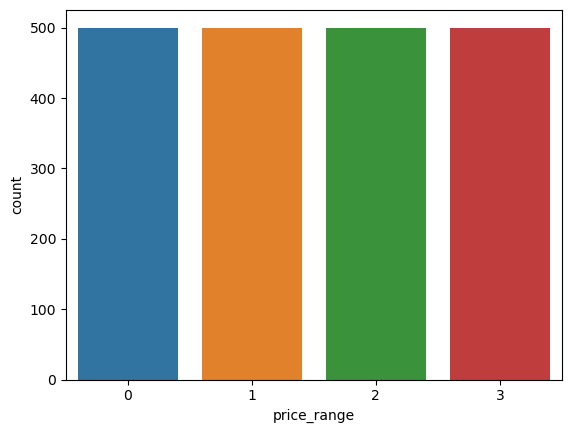

In [10]:
display(data.shape)
display(data["price_range"].value_counts())
sns.countplot(x='price_range', data=data)

['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']


<Figure size 1000x400 with 0 Axes>

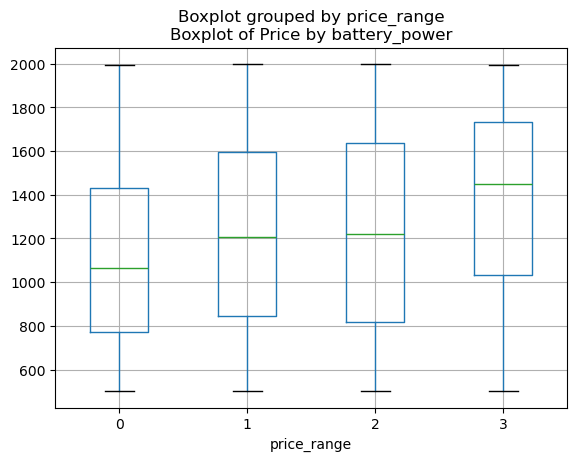

<Figure size 1000x400 with 0 Axes>

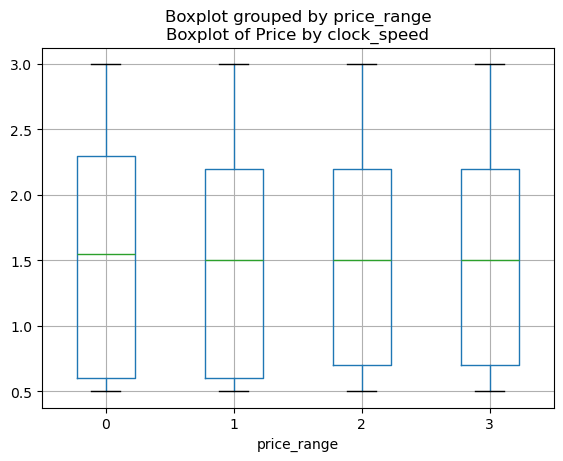

<Figure size 1000x400 with 0 Axes>

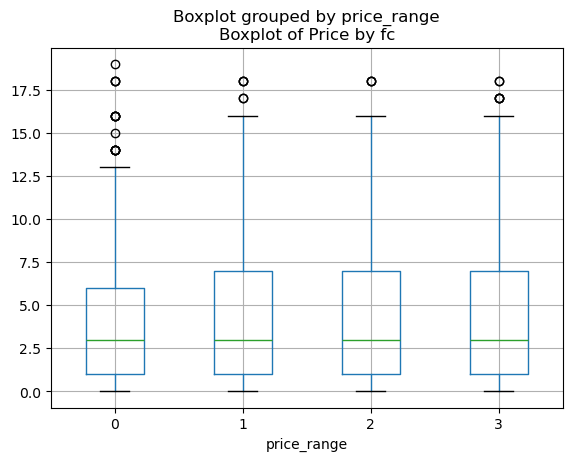

<Figure size 1000x400 with 0 Axes>

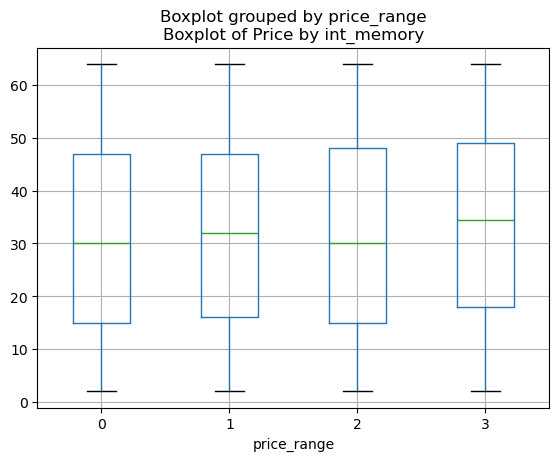

<Figure size 1000x400 with 0 Axes>

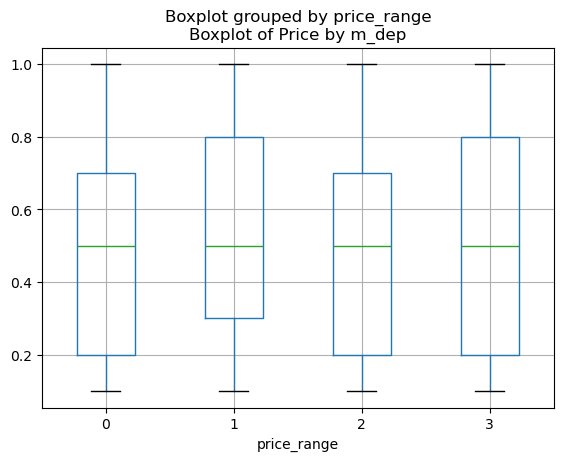

<Figure size 1000x400 with 0 Axes>

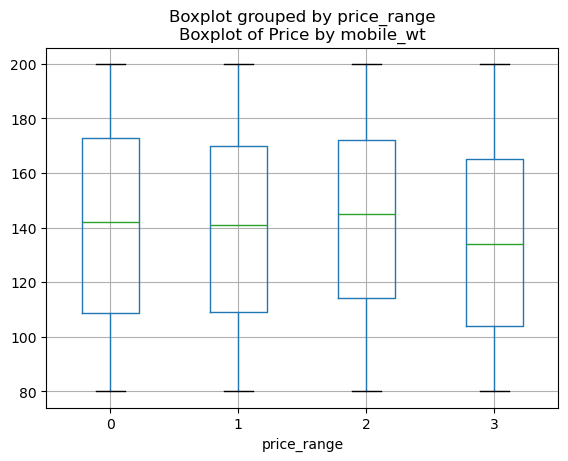

<Figure size 1000x400 with 0 Axes>

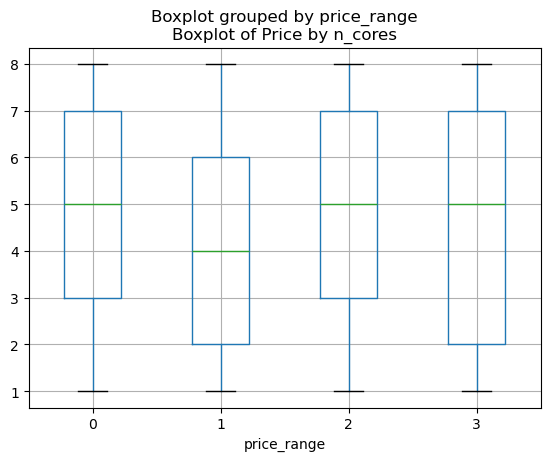

<Figure size 1000x400 with 0 Axes>

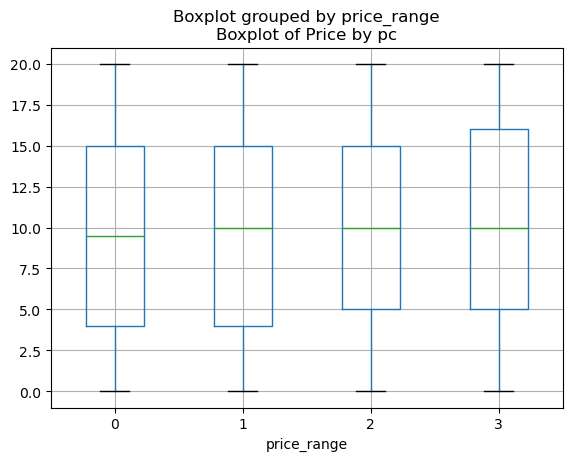

<Figure size 1000x400 with 0 Axes>

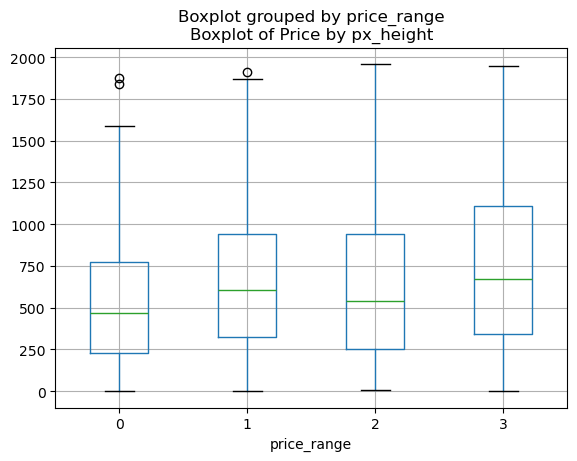

<Figure size 1000x400 with 0 Axes>

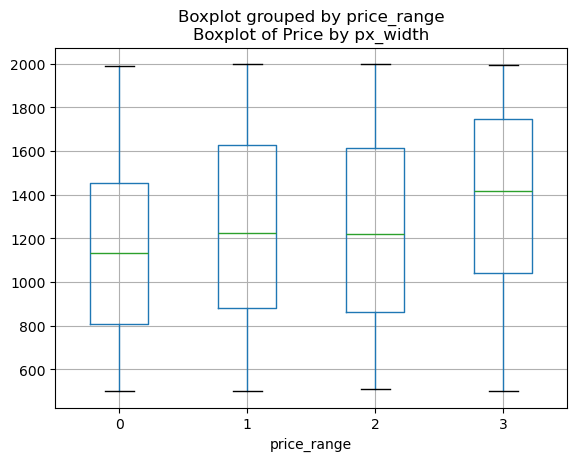

<Figure size 1000x400 with 0 Axes>

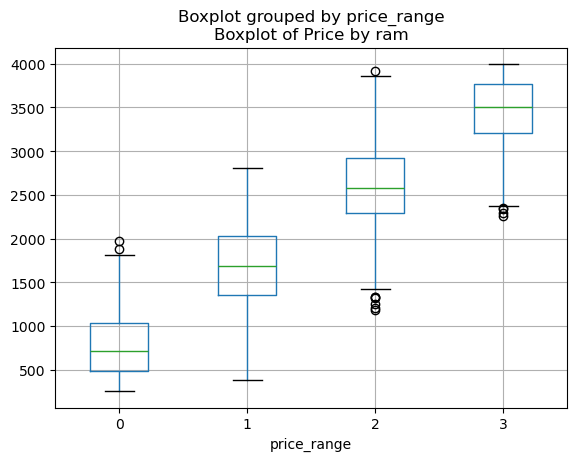

<Figure size 1000x400 with 0 Axes>

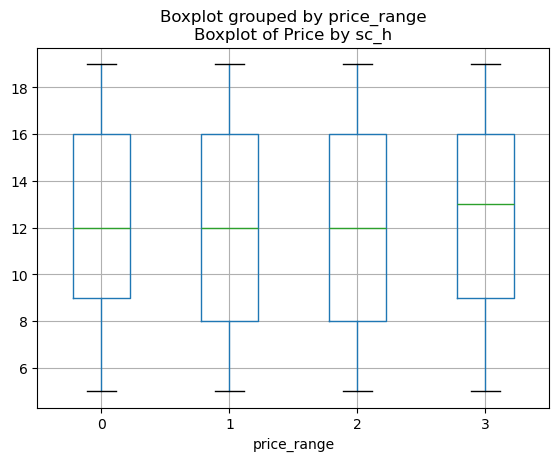

<Figure size 1000x400 with 0 Axes>

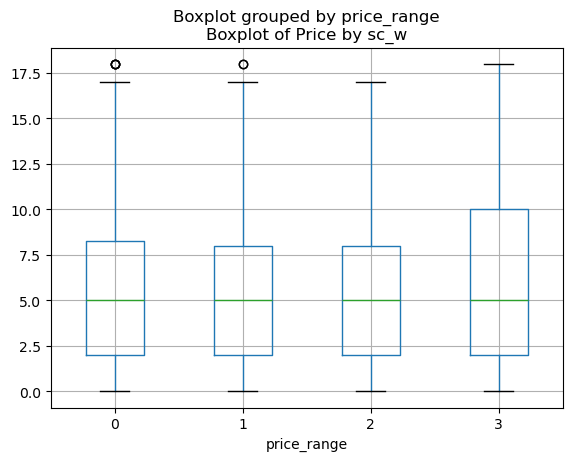

<Figure size 1000x400 with 0 Axes>

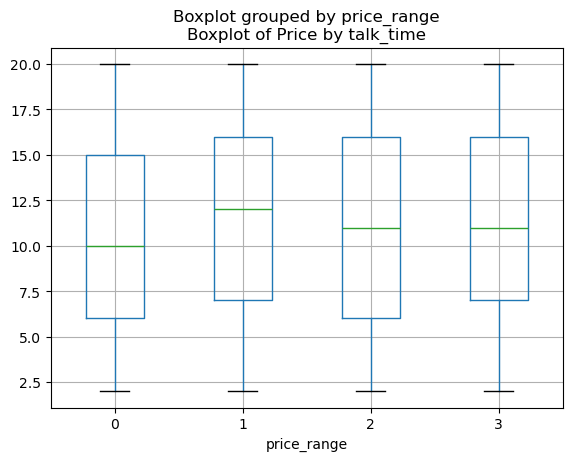

In [11]:
# Exploratory Data Analysis 
binary_features = [col for col in data.columns if data[col].nunique() == 2]
numeric_features = [col for col in data.select_dtypes(include=[np.number]).columns if col not in binary_features and col != 'price_range']
print(binary_features)
print(numeric_features)
for column in data[numeric_features]:
    if column != 'price_range':
        plt.figure(figsize=(10, 4))
        data.boxplot(column=column, by='price_range')
        plt.title(f'Boxplot of Price by {column}')
        plt.show()

### Noise Dectection
    As seen px_height (Pixel Resolution Height) and sc_w (Screen Width of mobile in cm) contain many values of zero and close to zero, which look like noise

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


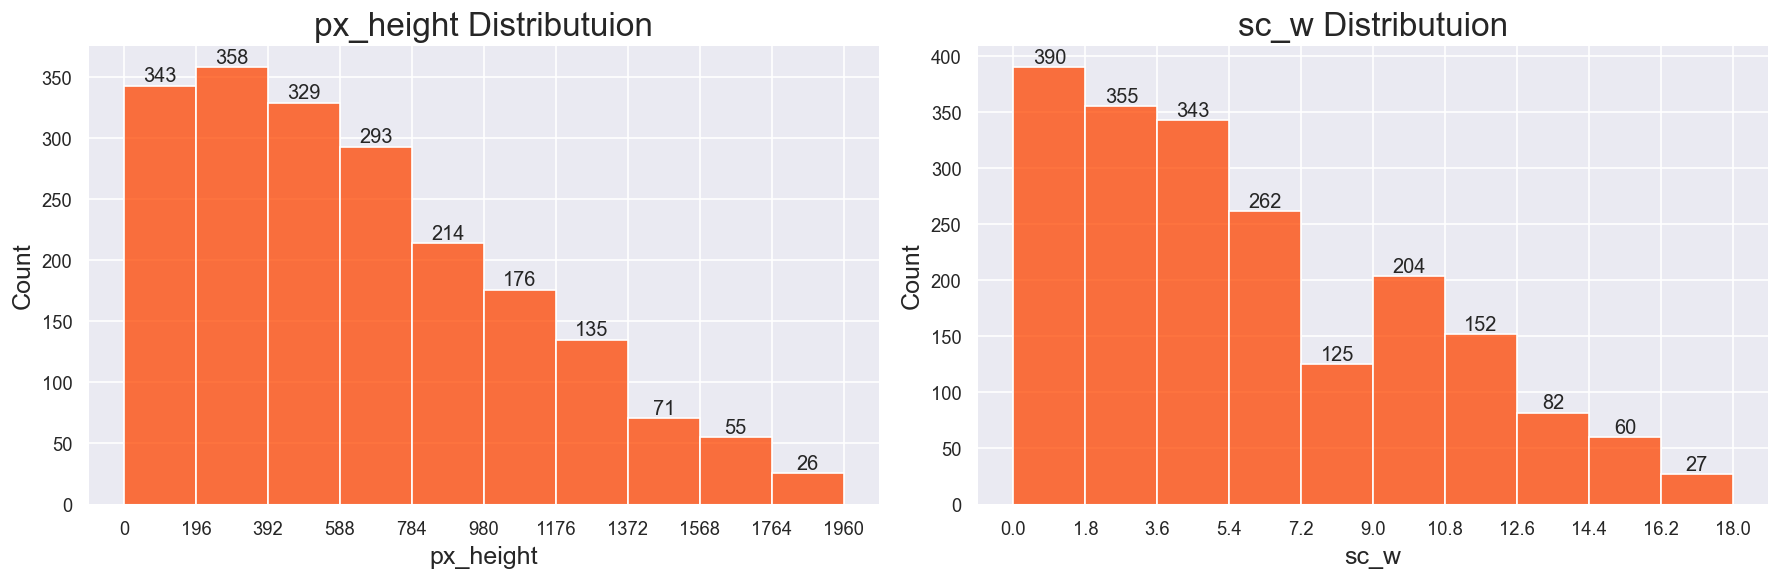

In [12]:
def show_noise (data):
    sns.set(rc = {'axes.labelsize' : 15})               
    fig, ax = plt.subplots(1, 2, figsize=(15,5), dpi=120)
    
    
    # Plot px_height histogram:
    _, bin_edges = np.histogram(data['px_height'], range=(np.floor(data['px_height'].min()), np.ceil(data['px_height'].max())))                                     
    graph1 = sns.histplot(x='px_height', data=data, bins=bin_edges, color='orangered', ax=ax[0])
    ax[0].set_xticks(bin_edges)
    ax[0].set_title('px_height Distributuion', fontsize=20) 
    for cont in graph1.containers:
            graph1.bar_label(cont)
    
    # Plot sc_w histogram:
    _, bin_edges = np.histogram(data['sc_w'], range=(np.floor(data['sc_w'].min()), np.ceil(data['sc_w'].max())))
    graph2 = sns.histplot(x='sc_w', data=data, bins=bin_edges, color='orangered', ax=ax[1])
    ax[1].set_xticks(bin_edges)
    ax[1].set_title('sc_w Distributuion', fontsize=20)      
    for cont in graph2.containers:
            graph2.bar_label(cont)
            
    plt.tight_layout()
    plt.show()
show_noise(data)

In [13]:
# Detect Noise values in sc_w 
sc_w_NoiseIndex = data[data['sc_w'] < 2].index

# Detect Noise values in px_height
px_height_NoiseIndex = data[data['px_height'] < 5].index

print('The number of detected noise values for sc_w: ', len(sc_w_NoiseIndex))
print('The number of detected noise values for px_height: ', len(px_height_NoiseIndex))

The number of detected noise values for sc_w:  390
The number of detected noise values for px_height:  9


### Pre-processing

#### Handle Missing values

#### Handle Noise values ( KNN imputer)

KNN Imputer:
KNN Imputer is a machine learning technique used to impute or fill in missing values and noise values in a dataset. The technique works by finding the k-nearest neighbors of a data point with missing values and then imputing the missing values with the average of those neighbors.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


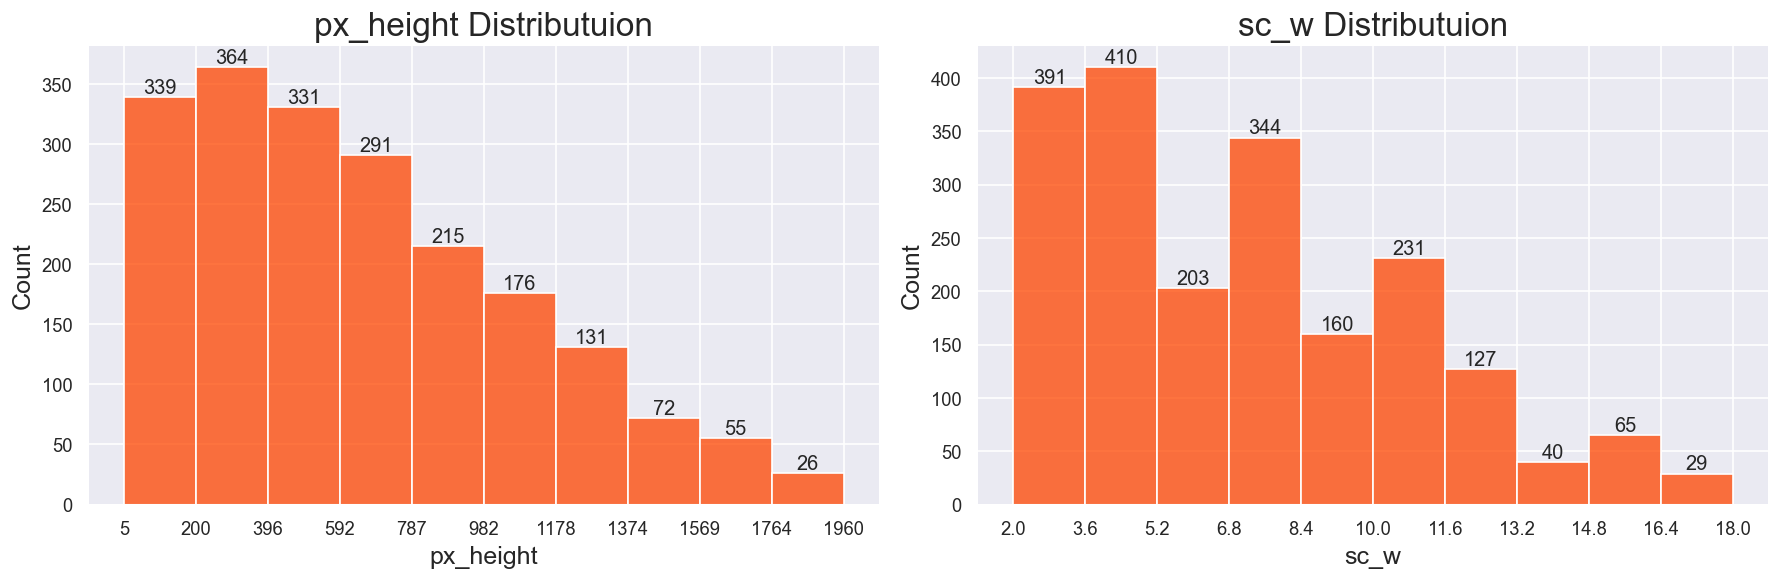

In [14]:
# Make a copy of dataset
data_denoised = data.copy()

# Replace the noise values with NaN
data_denoised.loc[sc_w_NoiseIndex,'sc_w'] = np.nan
data_denoised.loc[px_height_NoiseIndex,'px_height'] = np.nan

# Create a KNN imputer object with k=2
imputer = KNNImputer(n_neighbors=2)

# Impute the noise values
imputed_data = imputer.fit_transform(data_denoised)

# Convert array to dataframe
data_denoised = pd.DataFrame(imputed_data, columns=data_denoised.columns)

# Define the features (X) and the output labels (y)
X_denoised = data_denoised.drop('price_range', axis=1)
data_denoised['price_range'] = data_denoised['price_range'].astype(int)
y_denoised = data_denoised['price_range'] 

show_noise(data_denoised)

# Models


## Define Functions for using later

### Define a function that finds the optimal combination of hyperparameters to achieve the best accuracy for our classifier. The function uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters, and selects the combination with the highest accuracy

In [15]:
def tune_hyperparameters(clf, param_grid, X_train, y_train):
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    # GridSearVC with cross-validation (5 folds)
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, return_train_score=True)
    
    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)
    
    # Extract all accuracy scores and their corresponding hyperparameters
    results = clf_grid.cv_results_
    all_accuracies = results['mean_test_score']
    all_params = results['params']
    
    # Combine the parameters and accuracies into a list of dictionaries for better readability
    accuracies_with_params = [{'params': params, 'accuracy': accuracy} for params, accuracy in zip(all_params, all_accuracies)]
    
    # Print all accuracy scores with their corresponding hyperparameters
    for item in accuracies_with_params:
        print(f"Hyperparameters: {item['params']}, Accuracy: {item['accuracy']:.4f}")

    # Get the best hyperparameters
    print("Best hyperparameters:\n", clf_grid.best_params_)
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_

### Define Drop-column Feature Importances 

In [16]:
def drop_column_importance(model, X_train, y_train, random_state=0):
    # list containing feature importances
    importances = []
    # Clone the model
    model_clone = clone(model)
    # Set random_state for comparability
    model_clone.random_state = random_state
    # Train the model
    model_clone.fit(X_train, y_train)
    # Create the cross-validation object using StratifiedKFold 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    # Score the benchmark model using cross-validation
    benchmark_score = cross_val_score(model_clone, X_train, y_train, cv=cv, scoring='accuracy').mean()

    
    # Iterate over all features and store feature importance
    for col in X_train.columns:
        # Clone the model
        model_clone = clone(model)
        # Set random_state for comparability
        model_clone.random_state = random_state
        # Traint the model on the the dataset with a single feature removed
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        # Score the droped-column model
        drop_column_score = cross_val_score(model_clone, X_train.drop(col,axis=1), y_train, cv=cv, scoring='accuracy').mean()
        # Store feature importance which is defined as the difference between the benchmark and the new model score
        importances.append(benchmark_score - drop_column_score)
        
    # Return the features along with their importances in the form of a dataframe
    importances_df = pd.DataFrame({'feature': X_train.columns, 'feature importance': importances}) \
                     .sort_values('feature importance', ascending = False).reset_index(drop = True)
           
    return importances_df      

### Define a function to visualize the results of Drop-column Feature Importance technique using bar charts:

In [17]:
def drop_column_importance_plot(model, X_train, y_train):
    
    # Call drop-column feature importance function
    df_drop_column = drop_column_importance(model, X_train, y_train, random_state=0)
    # Rename columns
    df_drop_column.columns = ['Feature', 'Feature Importance']
    
    # Plot barchart
    plt.figure(figsize=(12,10))
    sns.barplot(data=df_drop_column, x='Feature Importance', y='Feature', orient='h', color='orangered')
    plt.title('Drop Column Feature Importance', fontsize=20)
    plt.show()

## SVC
### Pine line 1: 
    1. StandardScaler 
    2. Hyperparameter Tunning with GridSearchCV (cross-validation (5 folds)) 
    3. Support Vector Classifier (SVC)

### Scale Data using Standard Scaler

#### Define the features (X) and the output labels (y) of the given dataset:

In [18]:
X = data.drop('price_range', axis=1)
y = data['price_range'] 

#### Perform train test split:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train.head()
y_train.head()

538     2
1094    0
1654    0
8       0
1256    3
Name: price_range, dtype: int64

#### Scale data using StandardScaler:

In [20]:
# Scale the training and test data using Standard Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
# Convert training and test sets from numpy array to pandas dataframes
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_train.head()
X_test.head()


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1.365232,0.995012,0.119198,1.010051,-0.342193,-1.128152,-0.311507,-1.371891,-0.198945,0.653335,0.913804,-0.493071,-0.267954,0.889225,-1.702370,-1.243335,1.271968,-1.969276,1.0,-1.0
1,0.436537,0.995012,1.531918,1.010051,-1.042929,-1.128152,-0.642019,0.345119,1.127835,0.198841,-1.643409,-1.019416,-0.128258,0.481466,0.722658,-1.243335,1.454854,0.507801,-1.0,-1.0
2,-1.127817,0.995012,-1.293522,1.010051,-0.342193,0.886405,-0.256422,-1.371891,-0.833492,0.198841,-0.045151,-1.295341,-0.950135,1.377792,-0.732359,-0.322772,0.723312,0.507801,1.0,-1.0
3,1.056418,0.995012,-1.293522,-0.990050,2.694331,-1.128152,-0.586933,-1.371891,0.435602,-0.255653,1.553107,-1.195637,-0.361084,-0.890423,0.965161,-1.243335,1.271968,0.507801,1.0,-1.0
4,-0.598101,0.995012,-1.293522,-0.990050,2.460752,-1.128152,1.175795,1.718727,-0.285474,1.562323,1.393281,-0.750447,-1.399489,1.009973,-0.004850,0.137509,-0.556886,0.507801,-1.0,-1.0


### SVM Hyperparameter Tuning

In [21]:
param_grid = {'kernel': ['linear'],
               'C': [ 0.1, 1, 10, 50, 100]
             }

In [22]:
# Create a SVC object
svm = SVC(probability=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
svm_optimized = tune_hyperparameters(svm, param_grid, X_train, y_train)

Hyperparameters: {'C': 0.1, 'kernel': 'linear'}, Accuracy: 0.9369
Hyperparameters: {'C': 1, 'kernel': 'linear'}, Accuracy: 0.9587
Hyperparameters: {'C': 10, 'kernel': 'linear'}, Accuracy: 0.9644
Hyperparameters: {'C': 50, 'kernel': 'linear'}, Accuracy: 0.9675
Hyperparameters: {'C': 100, 'kernel': 'linear'}, Accuracy: 0.9638
Best hyperparameters:
 {'C': 50, 'kernel': 'linear'}


### Evaluation

#### Define Evaluation Function

In [23]:
orangered_cmap = LinearSegmentedColormap.from_list('orangered', ['#FFECEC','orangered'])
def metrics_calculator(clf, X_test, y_test, model_name):

    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro')],
                          index=['Accuracy','Macro Precision','Macro Recall','Macro F1-score'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [24]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):

    # Set font scale
    sns.set(font_scale=1.5)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    print('\n')
    
    # Create figure and subplots 
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=90, figsize=(12, 5))
    
    
    # Report desired results as a summary in the form of a table
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax1.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 4.2)
    table.set_fontsize(12)
    ax1.axis('tight')
    # Hide the axes
    ax1.axis('off')
    # set the title
    ax1.set_title('{} Performance Summary on Test Data'.format(model_name), fontsize=18)
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('orangered')
              
    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=orangered_cmap, ax=ax2)
    ax2.set_title('Confusion Matrix for Test Data')                                     
    ax2.grid(False)
            
    plt.tight_layout()
    plt.show() 


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.98      0.97      0.98       400
           2       0.98      0.98      0.98       400
           3       0.99      0.99      0.99       400

    accuracy                           0.99      1600
   macro avg       0.99      0.99      0.99      1600
weighted avg       0.99      0.99      0.99      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       0.99      0.96      0.97       100
           2       0.97      0.98      0.98       100
           3       0.99      0.98      0.98       100

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98 

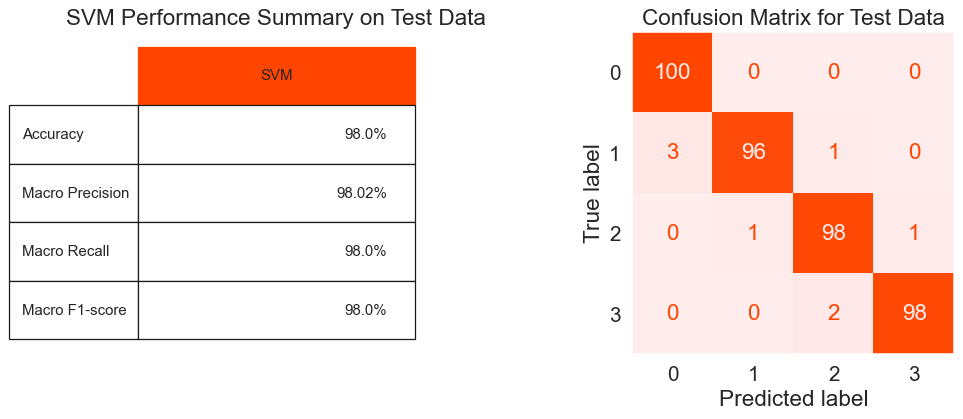

In [25]:
model_evaluation(svm_optimized, X_train, X_test, y_train, y_test, 'SVM')

In [26]:
# Save the final performance of SVM classifier
svm_result = metrics_calculator(svm_optimized, X_test, y_test, 'SVM')

## Decision Tree
### Pipeline 2: 
    1. Hyperparameter Tuning with GridSearchCV (cross-validation (5 folds))
    2. Drop unnecessary features
    3. Apply Decision Tree classifier 

#### Hyperparameter Tuning

In [27]:
# Define the hyperparameter grid
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': np.arange(1, 15),
              'min_samples_split': np.arange(2, 10),
              'min_samples_leaf': np.arange(1, 10),
              'max_features': [None, 'sqrt', 'log2']} 
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X_denoised, y_denoised, test_size=0.2, random_state=0, stratify=y)

# Create a  Decision Tree Classifier object
dt = DecisionTreeClassifier(random_state=0)

# Find the best classifier with the optimal hyperparameters
dt_optimized = tune_hyperparameters(dt, param_grid, X_train, y_train)

Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}, Accuracy: 0.4987
Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3}, Accuracy: 0.4987
Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4}, Accuracy: 0.4987
Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}, Accuracy: 0.4987
Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 6}, Accuracy: 0.4987
Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 7}, Accuracy: 0.4987
Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 8}, Accuracy: 0.4987
Hyperp

#### Drop Unnecessary Columns

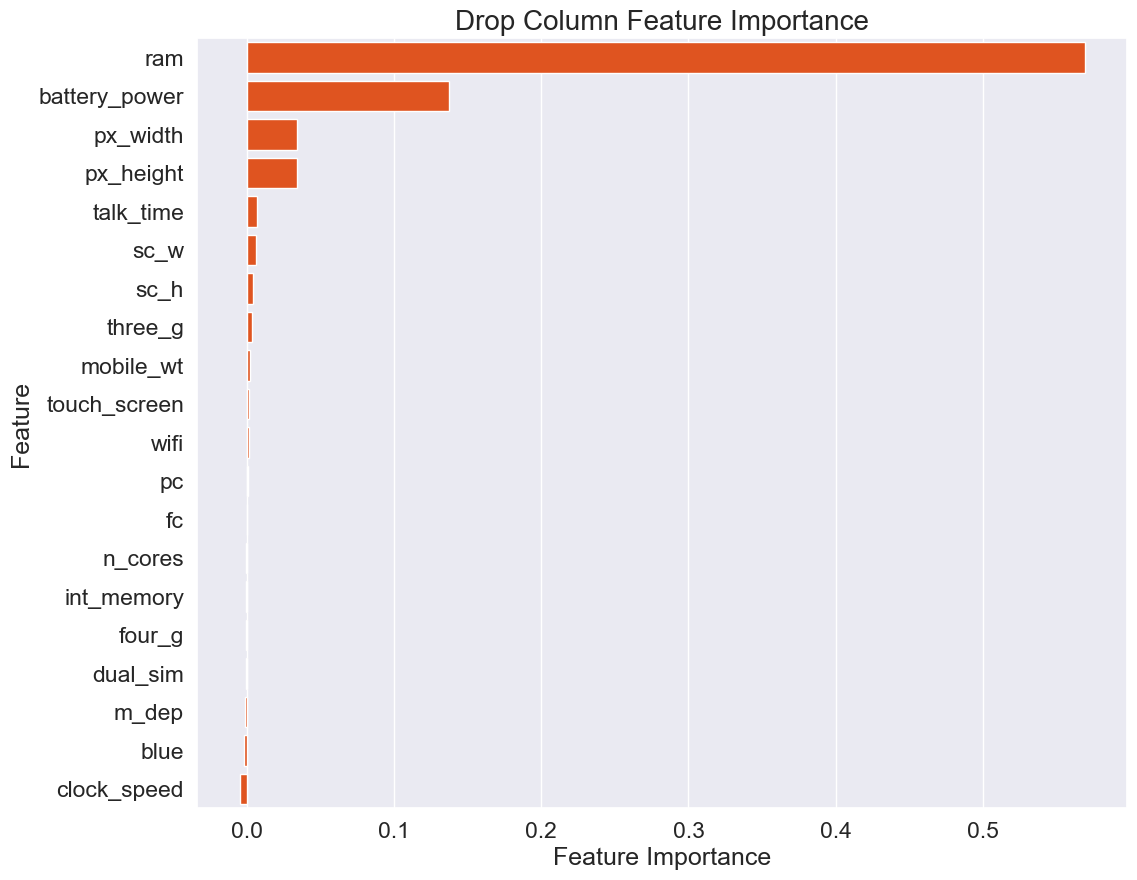

,ram,battery_power,px_width,px_height
538,3653.0,704.0,1013.0,251.0
1094,391.0,688.0,869.0,271.0
1654,512.0,1727.0,1288.0,376.0
8,1099.0,1445.0,836.0,386.0
1256,3105.0,1747.0,873.0,800.0
...,...,...,...,...
1399,1403.0,672.0,1267.0,574.0
1106,398.0,1266.0,1595.0,1187.0
1228,574.0,1820.0,1951.0,1157.0
1478,3011.0,1254.0,1021.0,204.0


,ram,battery_power,px_width,px_height
390,3097.0,1836.0,1139.0,408.0
1702,2658.0,1424.0,1199.0,181.0
1313,3623.0,730.0,846.0,62.0
1707,1181.0,1699.0,1099.0,105.0
1004,3227.0,965.0,653.0,297.0
...,...,...,...,...
205,2243.0,765.0,1429.0,1277.0
417,2244.0,651.0,858.0,548.0
1405,1724.0,1973.0,507.0,127.0
775,595.0,1160.0,859.0,762.0


In [28]:
drop_column_importance_plot(dt_optimized, X_train, y_train)
# Find Important features with positive feature_importance value
feature_importances = drop_column_importance(dt_optimized, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0.01]['feature']  # Threshold value of 0.01

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]
display(X_train)
display(X_test)


In [29]:
pd.DataFrame(selected_features)

,feature
0,ram
1,battery_power
2,px_width
3,px_height


#### Apply Decision Tree classifier 

In [30]:
display(X_train.columns)
display(X_test.columns)
# display(y_train.head)
# display(y_test.head())

Index(['ram', 'battery_power', 'px_width', 'px_height'], dtype='object')

Index(['ram', 'battery_power', 'px_width', 'px_height'], dtype='object')

In [36]:
y_pred_train = dt_optimized.predict(X_test)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- blue
- clock_speed
- dual_sim
- fc
- four_g
- ...


# Metrics

# Evaluations